In [7]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from collections import OrderedDict
import os
import neptune
from neptune.utils import stringify_unsupported

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [2]:
stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/freqRTheta.npz'
timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain.npz'
timeFreqSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeFreqRTheta.npz'

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/model.pth'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1.
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [3]:
epochs = 5000
batch_size = 64
learningRate = 1e-3
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 50

# UTILITY FUNCTIONS

In [4]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

# LOAD NUMPY DATA ARRAYS

In [5]:
dataSwitch = 'timeFreq'

if dataSwitch == 'freq':
    # STFT DATA

    npzfile = np.load(stftSavePath)
    x_trainRTheta = npzfile['x_trainRTheta']
    x_validRTheta = npzfile['x_validRTheta'] 
    y_trainRTheta = npzfile['y_trainRTheta'] 
    y_validRTheta = npzfile['y_validRTheta']

    trainXTensor = torch.Tensor(x_trainRTheta)
    trainYTensor = torch.Tensor(y_trainRTheta)
    validXTensor = torch.Tensor(x_validRTheta)
    validYTensor = torch.Tensor(y_validRTheta)

elif dataSwitch == 'time':
    # TIME DOMAIN DATA

    npzfile = np.load(timeDomainSavePath)
    xTrainTimeDomain = npzfile['xTrainTimeDomain']
    xValidTimeDomain = npzfile['xValidTimeDomain'] 
    yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
    yValidTimeDomain = npzfile['yValidTimeDomain']

    trainXTensor = torch.Tensor(xTrainTimeDomain)
    trainYTensor = torch.Tensor(yTrainTimeDomain)
    validXTensor = torch.Tensor(xValidTimeDomain)
    validYTensor = torch.Tensor(yValidTimeDomain)
    
elif dataSwitch == 'timeFreq':
    
    npzfile = np.load(timeFreqSavePath)
    xTrain = npzfile['x_trainTimeFreq']
    xValid = npzfile['x_validTimeFreq'] 
    yTrain = npzfile['y_trainTimeFreq'] 
    yValid = npzfile['y_validTimeFreq']

    trainXTensor = torch.Tensor(xTrain)
    trainYTensor = torch.Tensor(yTrain)
    validXTensor = torch.Tensor(xValid)
    validYTensor = torch.Tensor(yValid)

In [6]:
# CREATE PYTORCH DATALOADERS

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([64, 11397])
Shape of y: torch.Size([64, 67]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([64, 11397])
Shape of y: torch.Size([64, 67]) torch.float32


# DEFINE OR LOAD THE MODEL

In [16]:
# DEFINE MODEL

modelLoadFlag = False

if modelLoadFlag == True:
    model = torch.load(modelPath)
    bestTestLoss = test(validDataLoader, model, loss_fn)
else:
    # DEFINE ARCHITECTURE HERE
    hiddenLayerSizes = [512,512,512,512,512]
    
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = listToOrderedDict(layerSizeList)
    
    model = NeuralNetwork(layerOrderedDict)
    bestTestLoss = float('inf')
    
model = model.to(device)
print(model)

NeuralNetwork(
  (model): Sequential(
    (l0): Linear(in_features=2784, out_features=512, bias=True)
    (r0): ReLU()
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (r1): ReLU()
    (l2): Linear(in_features=512, out_features=512, bias=True)
    (r2): ReLU()
    (l3): Linear(in_features=512, out_features=512, bias=True)
    (r3): ReLU()
    (l4): Linear(in_features=512, out_features=512, bias=True)
    (r4): ReLU()
    (l5): Linear(in_features=512, out_features=1, bias=True)
  )
)


# TRAIN (LOG DATA TO NEPTUNE)

In [17]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn),
    "architectureString": str(model)
}
run["parameters"] = PARAMS

noImprovementCount = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainDataLoader, model, loss_fn, optimizer)
    test_loss = test(validDataLoader, model, loss_fn)
    
    if test_loss < bestTestLoss:
        noImprovementCount = 0
        bestTestLoss = test_loss
        torch.save(model, modelPath)
        run["model_best"].upload(modelPath)
        run["best_test_loss"] =  bestTestLoss
        print("\nSaved a new best model!\n")
    else:
        noImprovementCount = noImprovementCount + 1
        
    run["train/loss"].append(train_loss)
    run["test/loss"].append(test_loss)
    
    if noImprovementCount >= patience:   
        print("Early stopping invoked....")
        break
        
run.stop()
print("Done!")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-30
Epoch 1
-------------------------------
loss: 0.754094  [   64/165120]
Test Error: 
 Avg loss: 0.683079 


Saved a new best model!

Epoch 2
-------------------------------
loss: 0.909980  [   64/165120]
Test Error: 
 Avg loss: 0.682843 


Saved a new best model!

Epoch 3
-------------------------------
loss: 0.734370  [   64/165120]
Test Error: 
 Avg loss: 0.682633 


Saved a new best model!

Epoch 4
-------------------------------
loss: 0.673188  [   64/165120]
Test Error: 
 Avg loss: 0.682445 


Saved a new best model!

Epoch 5
-------------------------------
loss: 0.660373  [   64/165120]
Test Error: 
 Avg loss: 0.682261 


Saved a new best model!

Epoch 6
-------------------------------
loss: 0.724613  [   64/165120]
Test Error: 
 Avg loss: 0.682066 


Saved a new best model!

Epoch 7
-------------------------------
loss: 0.525827  [   64/165120]
Test Error: 
 Avg loss: 0.681882 


Saved a new best model!

Epoch 8
-------

Test Error: 
 Avg loss: 0.671095 


Saved a new best model!

Epoch 61
-------------------------------
loss: 0.663951  [   64/165120]
Test Error: 
 Avg loss: 0.670773 


Saved a new best model!

Epoch 62
-------------------------------
loss: 0.807890  [   64/165120]
Test Error: 
 Avg loss: 0.670430 


Saved a new best model!

Epoch 63
-------------------------------
loss: 0.683498  [   64/165120]
Test Error: 
 Avg loss: 0.670067 


Saved a new best model!

Epoch 64
-------------------------------
loss: 0.761395  [   64/165120]
Test Error: 
 Avg loss: 0.669693 


Saved a new best model!

Epoch 65
-------------------------------
loss: 0.889324  [   64/165120]
Test Error: 
 Avg loss: 0.669339 


Saved a new best model!

Epoch 66
-------------------------------
loss: 0.614478  [   64/165120]
Test Error: 
 Avg loss: 0.668989 


Saved a new best model!

Epoch 67
-------------------------------
loss: 0.618881  [   64/165120]
Test Error: 
 Avg loss: 0.668615 


Saved a new best model!

Epoch 68

Test Error: 
 Avg loss: 0.632494 


Saved a new best model!

Epoch 121
-------------------------------
loss: 0.610205  [   64/165120]
Test Error: 
 Avg loss: 0.631244 


Saved a new best model!

Epoch 122
-------------------------------
loss: 0.734866  [   64/165120]
Test Error: 
 Avg loss: 0.630029 


Saved a new best model!

Epoch 123
-------------------------------
loss: 0.662694  [   64/165120]
Test Error: 
 Avg loss: 0.628726 


Saved a new best model!

Epoch 124
-------------------------------
loss: 0.671900  [   64/165120]
Test Error: 
 Avg loss: 0.627456 


Saved a new best model!

Epoch 125
-------------------------------
loss: 0.694546  [   64/165120]
Test Error: 
 Avg loss: 0.626140 


Saved a new best model!

Epoch 126
-------------------------------
loss: 0.618142  [   64/165120]
Test Error: 
 Avg loss: 0.624874 


Saved a new best model!

Epoch 127
-------------------------------
loss: 0.608341  [   64/165120]
Test Error: 
 Avg loss: 0.623627 


Saved a new best model!

E

Test Error: 
 Avg loss: 0.546073 


Saved a new best model!

Epoch 178
-------------------------------
loss: 0.627921  [   64/165120]
Test Error: 
 Avg loss: 0.544485 


Saved a new best model!

Epoch 179
-------------------------------
loss: 0.546550  [   64/165120]
Test Error: 
 Avg loss: 0.542962 


Saved a new best model!

Epoch 180
-------------------------------
loss: 0.497811  [   64/165120]
Test Error: 
 Avg loss: 0.541272 


Saved a new best model!

Epoch 181
-------------------------------
loss: 0.593660  [   64/165120]
Test Error: 
 Avg loss: 0.539434 


Saved a new best model!

Epoch 182
-------------------------------
loss: 0.726832  [   64/165120]
Test Error: 
 Avg loss: 0.537429 


Saved a new best model!

Epoch 183
-------------------------------
loss: 0.584519  [   64/165120]
Test Error: 
 Avg loss: 0.535407 


Saved a new best model!

Epoch 184
-------------------------------
loss: 0.623210  [   64/165120]
Test Error: 
 Avg loss: 0.533722 


Saved a new best model!

E

Test Error: 
 Avg loss: 0.496189 

Epoch 239
-------------------------------
loss: 0.413737  [   64/165120]
Test Error: 
 Avg loss: 0.495097 


Saved a new best model!

Epoch 240
-------------------------------
loss: 0.575836  [   64/165120]
Test Error: 
 Avg loss: 0.493873 


Saved a new best model!

Epoch 241
-------------------------------
loss: 0.603935  [   64/165120]
Test Error: 
 Avg loss: 0.492309 


Saved a new best model!

Epoch 242
-------------------------------
loss: 0.477917  [   64/165120]
Test Error: 
 Avg loss: 0.490935 


Saved a new best model!

Epoch 243
-------------------------------
loss: 0.498645  [   64/165120]
Test Error: 
 Avg loss: 0.489907 


Saved a new best model!

Epoch 244
-------------------------------
loss: 0.449641  [   64/165120]
Test Error: 
 Avg loss: 0.488914 


Saved a new best model!

Epoch 245
-------------------------------
loss: 0.488828  [   64/165120]
Test Error: 
 Avg loss: 0.488250 


Saved a new best model!

Epoch 246
-----------------

Test Error: 
 Avg loss: 0.469235 


Saved a new best model!

Epoch 302
-------------------------------
loss: 0.505412  [   64/165120]
Test Error: 
 Avg loss: 0.468963 


Saved a new best model!

Epoch 303
-------------------------------
loss: 0.419311  [   64/165120]
Test Error: 
 Avg loss: 0.468785 


Saved a new best model!

Epoch 304
-------------------------------
loss: 0.459471  [   64/165120]
Test Error: 
 Avg loss: 0.468704 


Saved a new best model!

Epoch 305
-------------------------------
loss: 0.397934  [   64/165120]
Test Error: 
 Avg loss: 0.468605 


Saved a new best model!

Epoch 306
-------------------------------
loss: 0.406155  [   64/165120]
Test Error: 
 Avg loss: 0.468607 

Epoch 307
-------------------------------
loss: 0.399650  [   64/165120]
Test Error: 
 Avg loss: 0.468612 

Epoch 308
-------------------------------
loss: 0.583846  [   64/165120]
Test Error: 
 Avg loss: 0.468369 


Saved a new best model!

Epoch 309
-------------------------------
loss: 0.439

Test Error: 
 Avg loss: 0.458157 

Epoch 363
-------------------------------
loss: 0.441596  [   64/165120]
Test Error: 
 Avg loss: 0.458099 

Epoch 364
-------------------------------
loss: 0.550469  [   64/165120]
Test Error: 
 Avg loss: 0.458450 

Epoch 365
-------------------------------
loss: 0.408093  [   64/165120]
Test Error: 
 Avg loss: 0.459191 

Epoch 366
-------------------------------
loss: 0.537128  [   64/165120]
Test Error: 
 Avg loss: 0.460083 

Epoch 367
-------------------------------
loss: 0.506060  [   64/165120]
Test Error: 
 Avg loss: 0.460534 

Epoch 368
-------------------------------
loss: 0.481083  [   64/165120]
Test Error: 
 Avg loss: 0.460775 

Epoch 369
-------------------------------
loss: 0.373744  [   64/165120]
Test Error: 
 Avg loss: 0.460649 

Epoch 370
-------------------------------
loss: 0.421863  [   64/165120]
Test Error: 
 Avg loss: 0.460325 

Epoch 371
-------------------------------
loss: 0.414993  [   64/165120]
Test Error: 
 Avg loss: 0.45

Test Error: 
 Avg loss: 0.450822 

Epoch 432
-------------------------------
loss: 0.450168  [   64/165120]
Test Error: 
 Avg loss: 0.452064 

Epoch 433
-------------------------------
loss: 0.353878  [   64/165120]
Test Error: 
 Avg loss: 0.453135 

Epoch 434
-------------------------------
loss: 0.384703  [   64/165120]
Test Error: 
 Avg loss: 0.453709 

Epoch 435
-------------------------------
loss: 0.492590  [   64/165120]
Test Error: 
 Avg loss: 0.453661 

Epoch 436
-------------------------------
loss: 0.399200  [   64/165120]
Test Error: 
 Avg loss: 0.453133 

Epoch 437
-------------------------------
loss: 0.464963  [   64/165120]
Test Error: 
 Avg loss: 0.452406 

Epoch 438
-------------------------------
loss: 0.467315  [   64/165120]
Test Error: 
 Avg loss: 0.451465 

Epoch 439
-------------------------------
loss: 0.502224  [   64/165120]
Test Error: 
 Avg loss: 0.450370 

Epoch 440
-------------------------------
loss: 0.398159  [   64/165120]
Test Error: 
 Avg loss: 0.44

Test Error: 
 Avg loss: 0.439412 


Saved a new best model!

Epoch 501
-------------------------------
loss: 0.405074  [   64/165120]
Test Error: 
 Avg loss: 0.439362 


Saved a new best model!

Epoch 502
-------------------------------
loss: 0.417839  [   64/165120]
Test Error: 
 Avg loss: 0.439341 


Saved a new best model!

Epoch 503
-------------------------------
loss: 0.433304  [   64/165120]
Test Error: 
 Avg loss: 0.439162 


Saved a new best model!

Epoch 504
-------------------------------
loss: 0.350424  [   64/165120]
Test Error: 
 Avg loss: 0.438886 


Saved a new best model!

Epoch 505
-------------------------------
loss: 0.356640  [   64/165120]
Test Error: 
 Avg loss: 0.438657 


Saved a new best model!

Epoch 506
-------------------------------
loss: 0.406424  [   64/165120]
Test Error: 
 Avg loss: 0.438498 


Saved a new best model!

Epoch 507
-------------------------------
loss: 0.454858  [   64/165120]
Test Error: 
 Avg loss: 0.438400 


Saved a new best model!

E

Test Error: 
 Avg loss: 0.434317 


Saved a new best model!

Epoch 571
-------------------------------
loss: 0.426784  [   64/165120]
Test Error: 
 Avg loss: 0.434912 

Epoch 572
-------------------------------
loss: 0.413039  [   64/165120]
Test Error: 
 Avg loss: 0.436108 

Epoch 573
-------------------------------
loss: 0.330876  [   64/165120]
Test Error: 
 Avg loss: 0.437238 

Epoch 574
-------------------------------
loss: 0.356524  [   64/165120]
Test Error: 
 Avg loss: 0.437565 

Epoch 575
-------------------------------
loss: 0.326915  [   64/165120]
Test Error: 
 Avg loss: 0.437701 

Epoch 576
-------------------------------
loss: 0.374902  [   64/165120]
Test Error: 
 Avg loss: 0.437723 

Epoch 577
-------------------------------
loss: 0.435193  [   64/165120]
Test Error: 
 Avg loss: 0.437392 

Epoch 578
-------------------------------
loss: 0.418083  [   64/165120]
Test Error: 
 Avg loss: 0.436969 

Epoch 579
-------------------------------
loss: 0.405057  [   64/165120]
Te

Test Error: 
 Avg loss: 0.429168 

Epoch 642
-------------------------------
loss: 0.325650  [   64/165120]
Test Error: 
 Avg loss: 0.429425 

Epoch 643
-------------------------------
loss: 0.399862  [   64/165120]
Test Error: 
 Avg loss: 0.430235 

Epoch 644
-------------------------------
loss: 0.413407  [   64/165120]
Test Error: 
 Avg loss: 0.431404 

Epoch 645
-------------------------------
loss: 0.409878  [   64/165120]
Test Error: 
 Avg loss: 0.432432 

Epoch 646
-------------------------------
loss: 0.370533  [   64/165120]
Test Error: 
 Avg loss: 0.433490 

Epoch 647
-------------------------------
loss: 0.379419  [   64/165120]
Test Error: 
 Avg loss: 0.433904 

Epoch 648
-------------------------------
loss: 0.333058  [   64/165120]
Test Error: 
 Avg loss: 0.433524 

Epoch 649
-------------------------------
loss: 0.461638  [   64/165120]
Test Error: 
 Avg loss: 0.433101 

Epoch 650
-------------------------------
loss: 0.495674  [   64/165120]
Test Error: 
 Avg loss: 0.43

# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


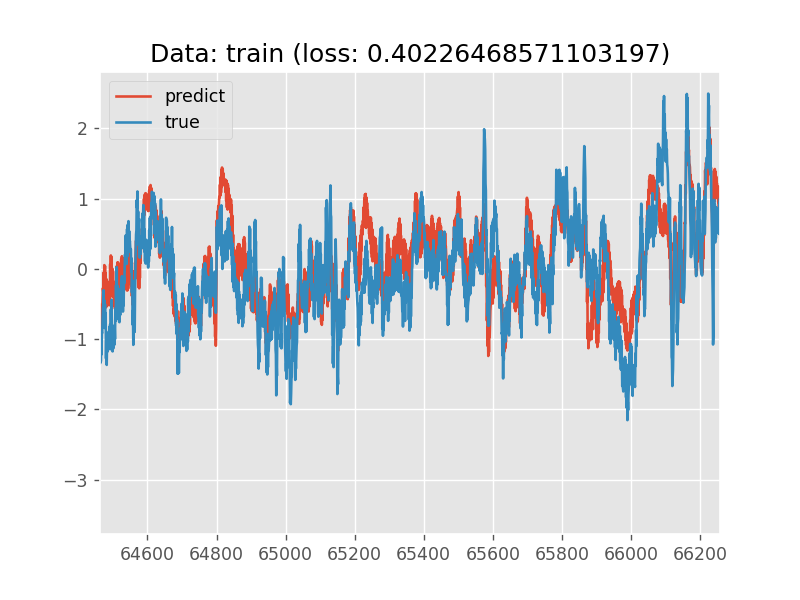

In [18]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = True
    
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'
    
x = x.to(device)
predict = model(x).cpu().detach().numpy()

if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'Data: ' + trainTitle + ' (loss: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

# SCRATCH BELOW

In [ ]:
import neptune

# Create a Neptune run object
run = neptune.init_run(
    project='jettinger35/test',
    api_token=api_token,  
)

# Track metadata and hyperparameters by assigning them to the run
run["JIRA"] = "NPT-952"
run["algorithm"] = "ConvNet"

PARAMS = {
    "batch_size": 64,
    "dropout": 0.2,
    "learning_rate": 0.001,
    "optimizer": "Adam",
}
run["parameters"] = PARAMS

# Track the training process by logging your training metrics
for epoch in range(10):
    run["train/accuracy"].append(epoch * 0.6)  
    run["train/loss"].append(epoch * 0.4)

# Record the final results
run["f1_score"] = 0.66

# Stop the connection and synchronize the data with the Neptune servers
run.stop()


# SCRATCH

In [60]:
from scipy.signal import spectrogram, stft, istft, check_NOLA

fs = 1
nperseg = 32
noverlap = 31
#windowType = ('tukey', .25)
windowType = np.ones(nperseg)


a = np.random.rand(100)
f, t, S = stft(a, fs=fs, window=windowType, nperseg=nperseg, noverlap=noverlap)

b = torch.stft(torch.tensor(a), 
               n_fft = nperseg, 
               hop_length = 1, 
               return_complex=True, 
               normalized=False, 
               onesided=True, 
               pad_mode='constant').numpy()

np.abs(np.divide(b,S))

array([[32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       ...,
       [32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.]])